# WISE BPIC 2019 Norm – Stakeholder Playbook

This markdown document analyses the norm defined in
`BPIC_2019_norm.json`fileciteturn10file0
and explains how such a norm can be elicited and refined with stakeholders in
a real P2P improvement programme. It is structured as a **playbook** that
guides:

1. how to *read* the norm,
2. how to *simulate workshops* with Finance, Logistics and other roles,
3. how to *decide on constraints* and *weights* in a business-aligned way,
4. how to *link the norm* to KPIs and BPIC'19 specifics,
5. how to *evolve* the norm over time.

The document can be opened directly in Jupyter using Jupytext or converted
into a notebook:

In [1]:
%%bash
#jupytext --to ipynb WISE_BPIC19_Norm_Playbook.md

---

## 1. What the BPIC'19 norm says

The file `BPIC_2019_norm.json` defines:

- two **views**: `Finance` and `Logistics`,
- ten **constraints**, organised into three WISE layers:

  - **L1 Presence**  
    - `c_l1_create_po`: `Create Purchase Order Item` must be present.  
    - `c_l1_gr`: `Record Goods Receipt` must be present.  
    - `c_l1_inv`: `Record Invoice Receipt` must be present.  
    - `c_l1_clear`: `Clear Invoice` must be present.

  - **L2 Order/Lag**  
    - `c_l2_gr_to_inv`: GR → INV in at most 10 days.  
    - `c_l2_inv_to_clear`: INV → CLEAR in at most 30 days.

  - **L4 Singularity**  
    - `c_l4_change_price_once`: `Change Price` should happen at most once.  
    - `c_l4_change_quantity_once`: `Change Quantity` should happen at most once.

  - **L5 Exclusion**  
    - `c_l5_cancel_invoice`: `Cancel Invoice Receipt` should not happen.  
    - `c_l5_cancel_gr`: `Cancel Goods Receipt` should not happen.

For each constraint there are:

- `base_weight` – a default importance (here always 1.0),
- `view_weights` – importance per view (`Finance` vs `Logistics`).

For example:

```json
{
  "id": "c_l2_gr_to_inv",
  "layer_id": "order_lag",
  "params": {
    "activity_from": "Record Goods Receipt",
    "activity_to": "Record Invoice Receipt",
    "max_days": 10
  },
  "base_weight": 1.0,
  "view_weights": {
    "Finance": 0.2,
    "Logistics": 0.4
  }
}
```

means:

- if GR→INV exceeds 10 days, the norm counts it as a violation,
- this violation is weighted more heavily in the `Logistics` view (0.4) than
  in the `Finance` view (0.2).

In WISE, each constraint contributes a **bounded violation**
$v_c(\sigma) \in [0,1]$ per case, and the view-specific case score is:

$$
S^{(v)}(\sigma) = 1 - \sum_c w_c^{(v)} v_c(\sigma).
$$

Scores are then aggregated across slices to obtain gaps and Priority Indices.

---



### 1.1. Short process exploration

Showing analysis for Item Category: 3-way match, invoice before GR
[INFO] Subset '3-way match, invoice before GR': 1,234,708 events, 221,010 cases

[PROCESS MODEL] Category: 3-way match, invoice before GR
Events: 1,234,708, Cases: 221,010


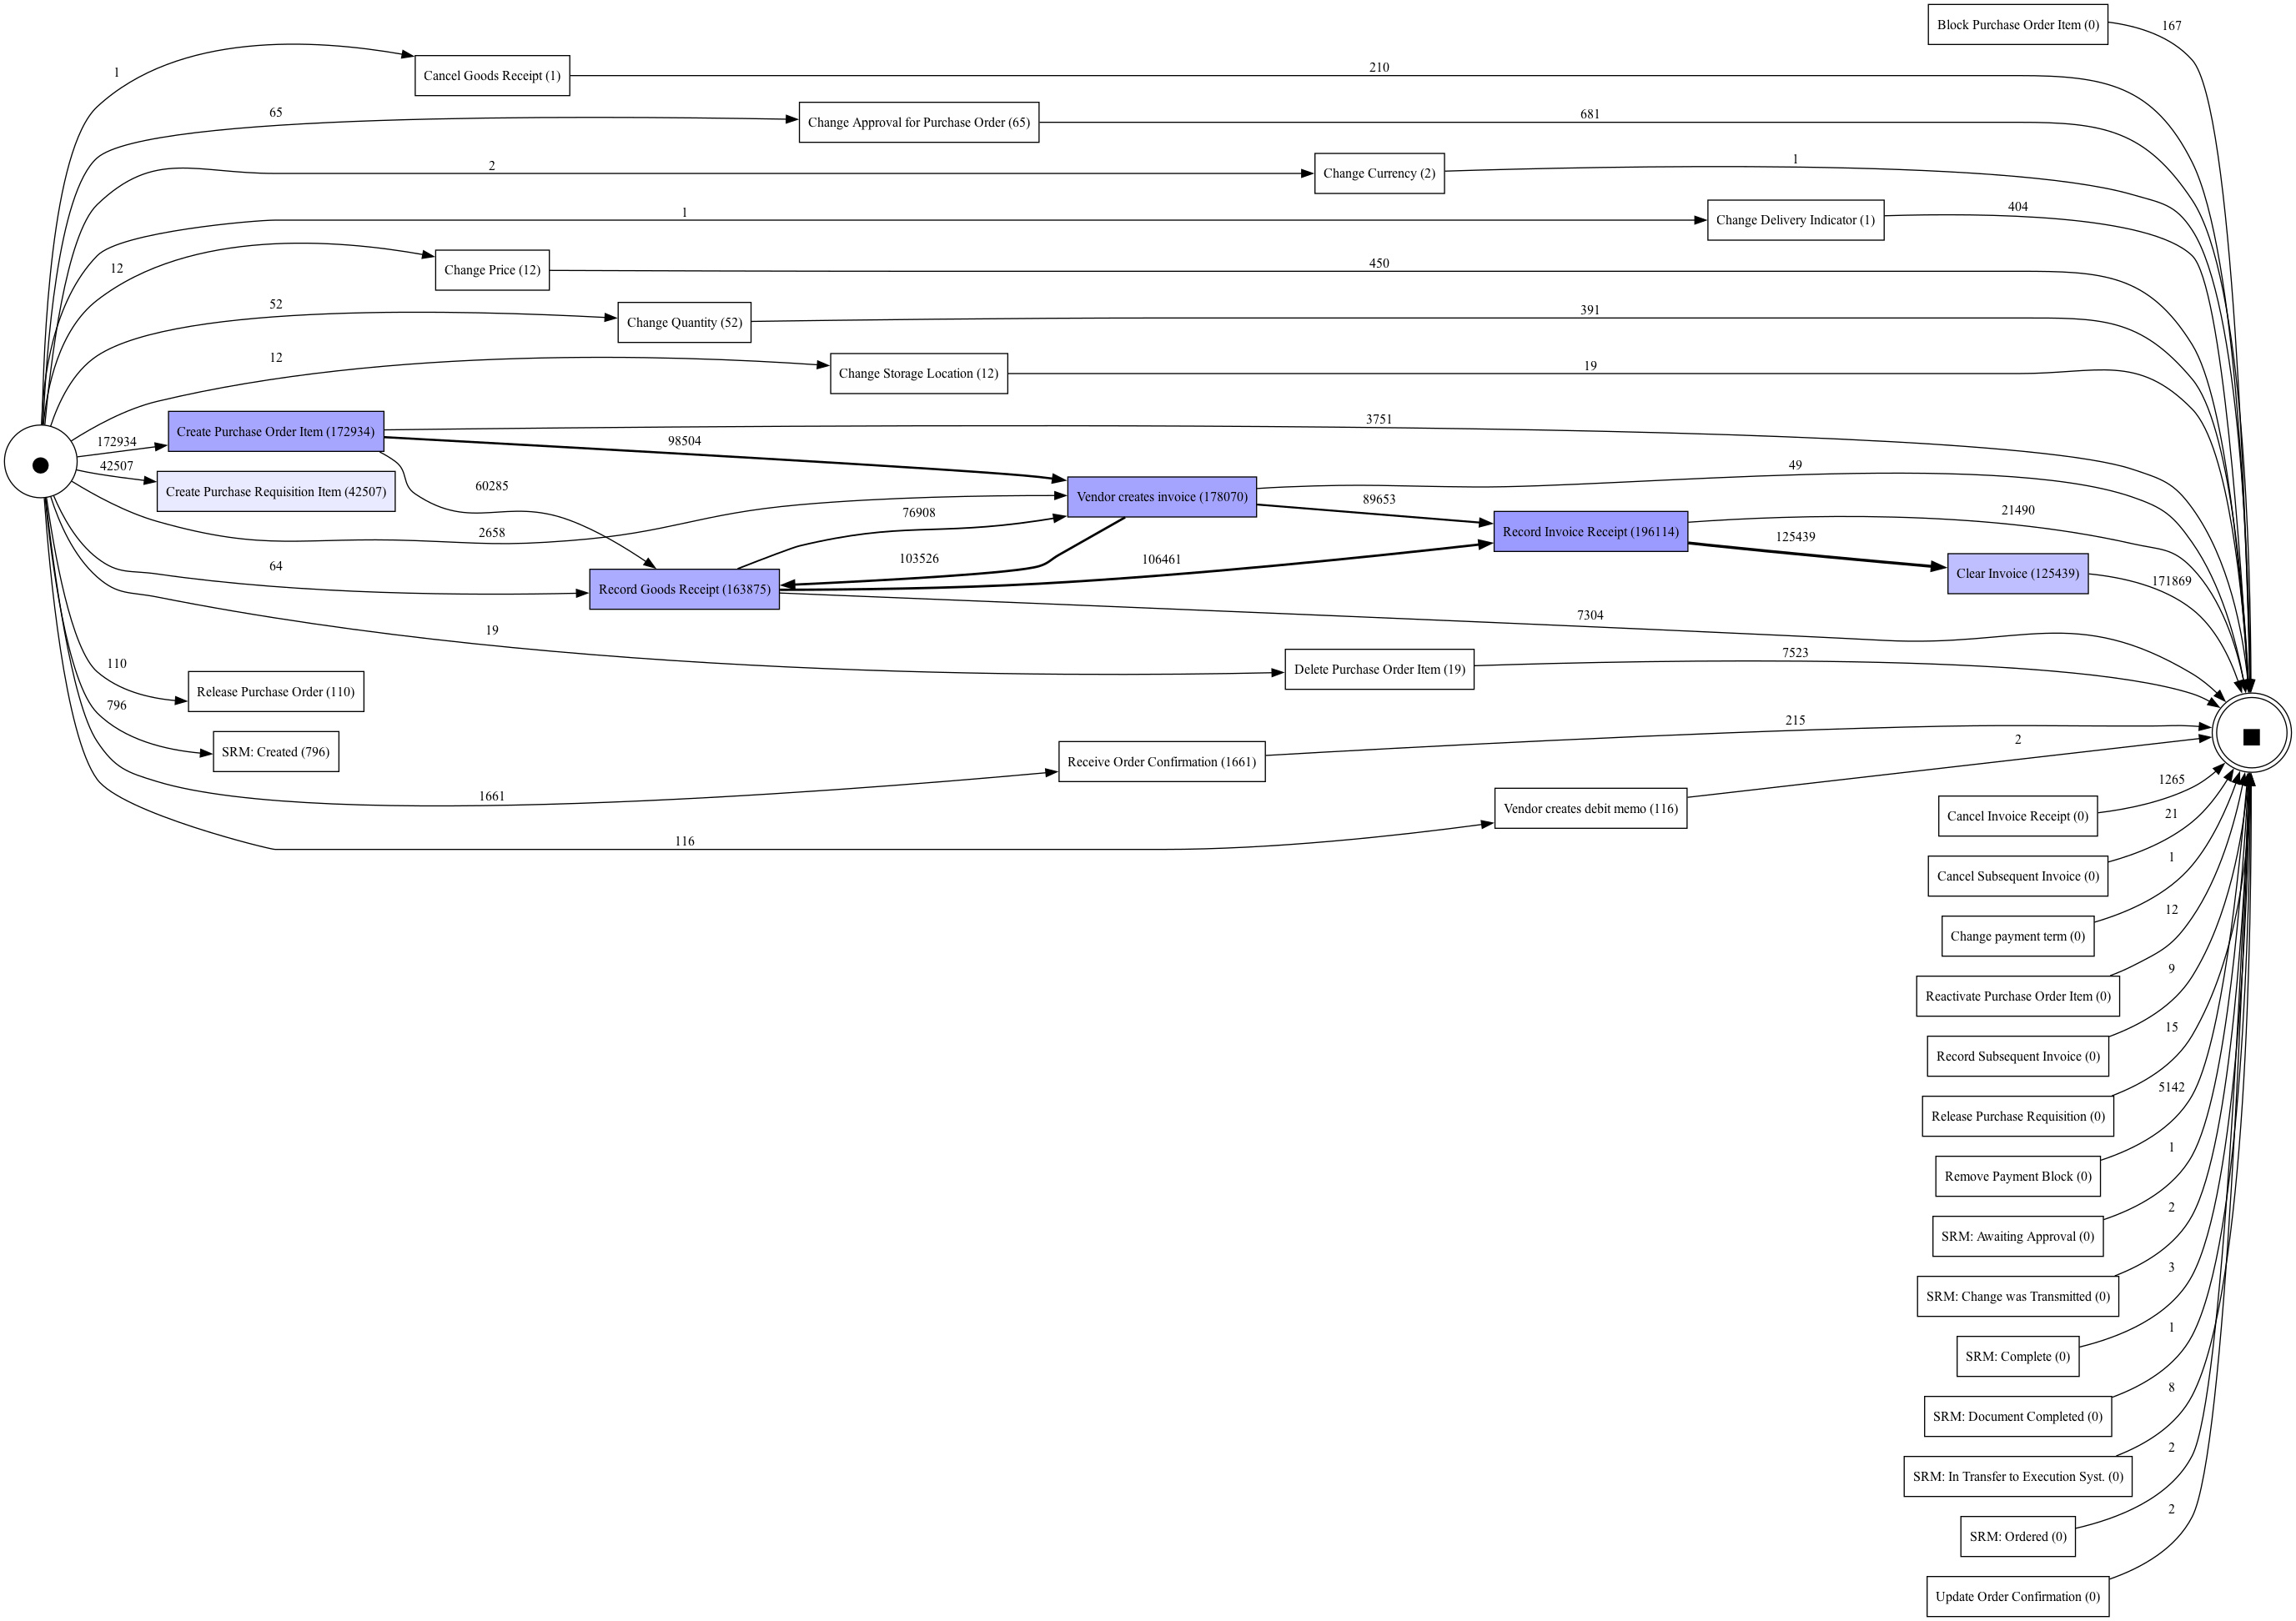

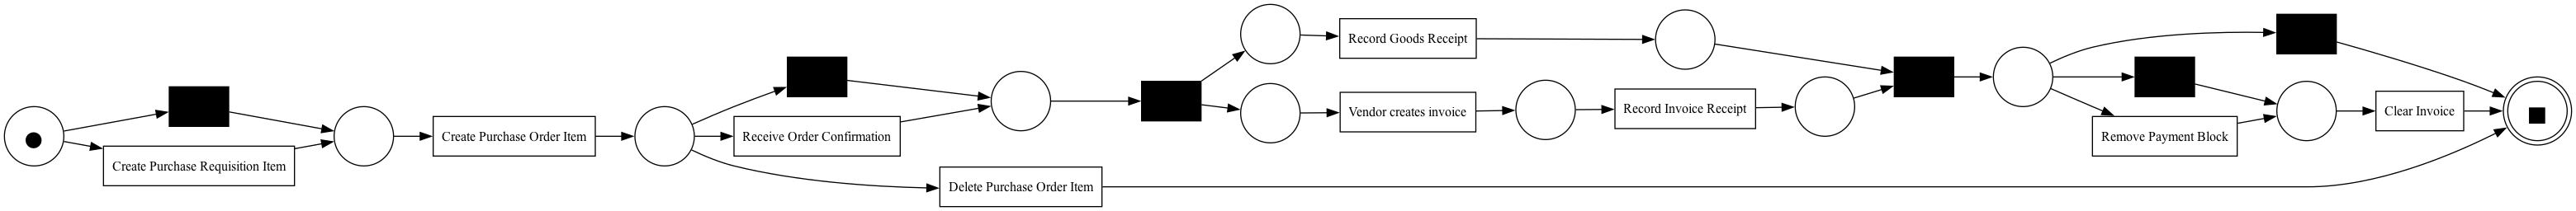

Showing analysis for Item Category: 3-way match, invoice after GR
[INFO] Subset '3-way match, invoice after GR': 319,233 events, 15,182 cases

[PROCESS MODEL] Category: 3-way match, invoice after GR
Events: 319,233, Cases: 15,182


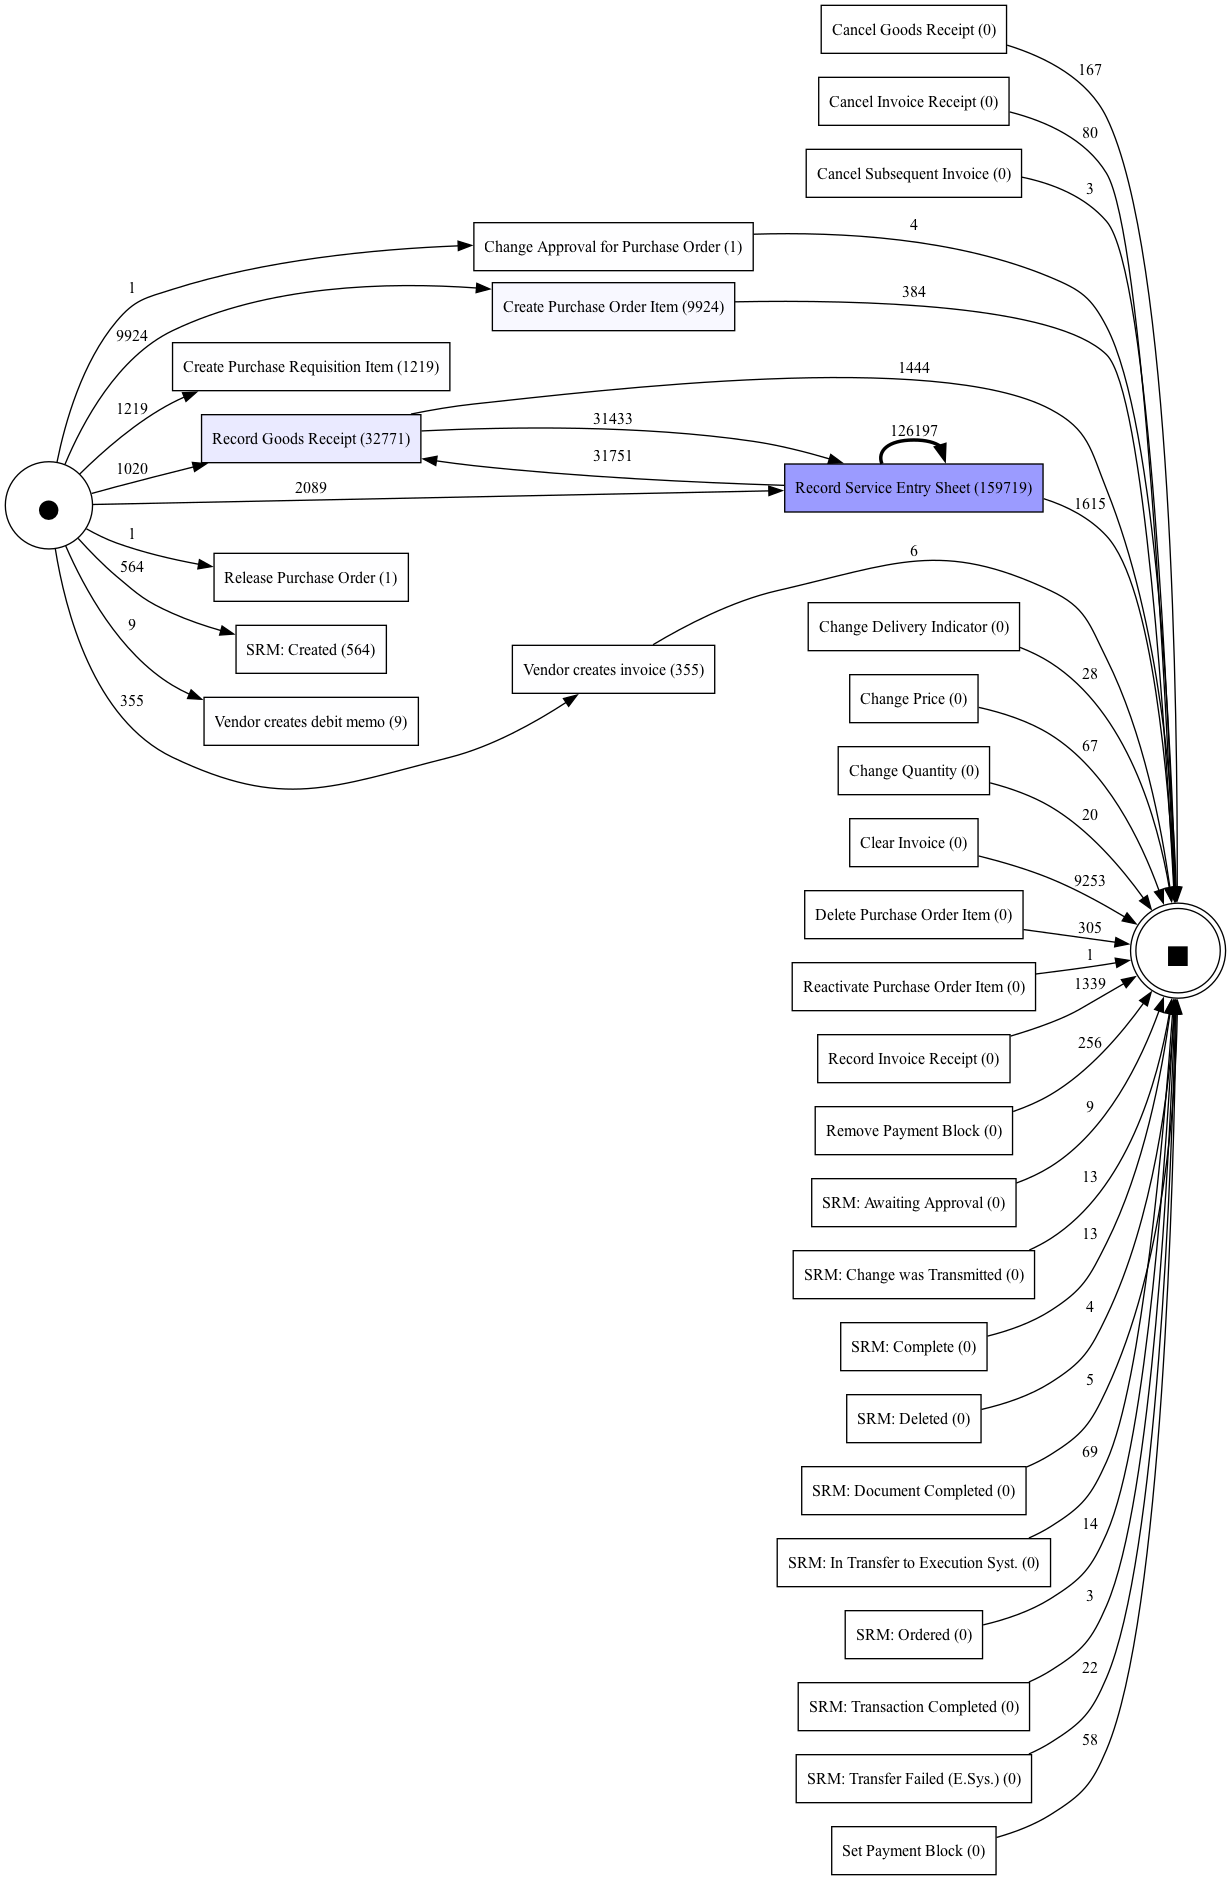

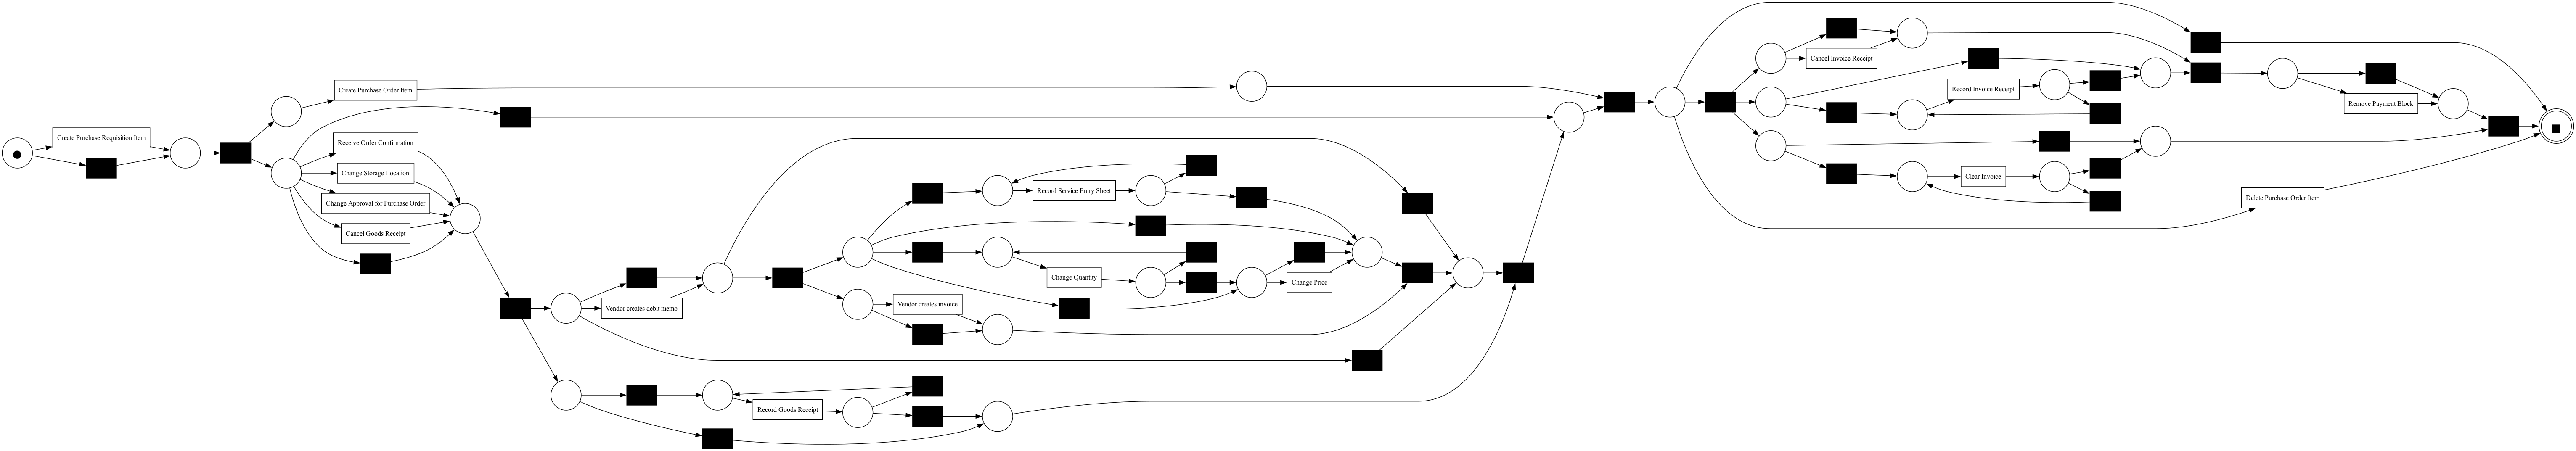

Showing analysis for Item Category: 2-way match
[INFO] Subset '2-way match': 5,898 events, 1,044 cases

[PROCESS MODEL] Category: 2-way match
Events: 5,898, Cases: 1,044


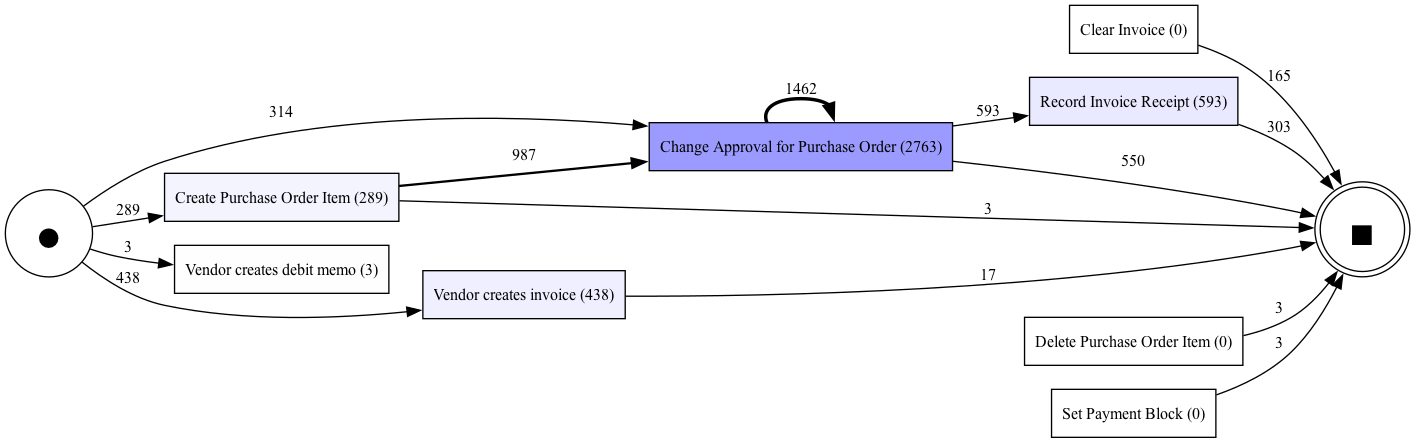

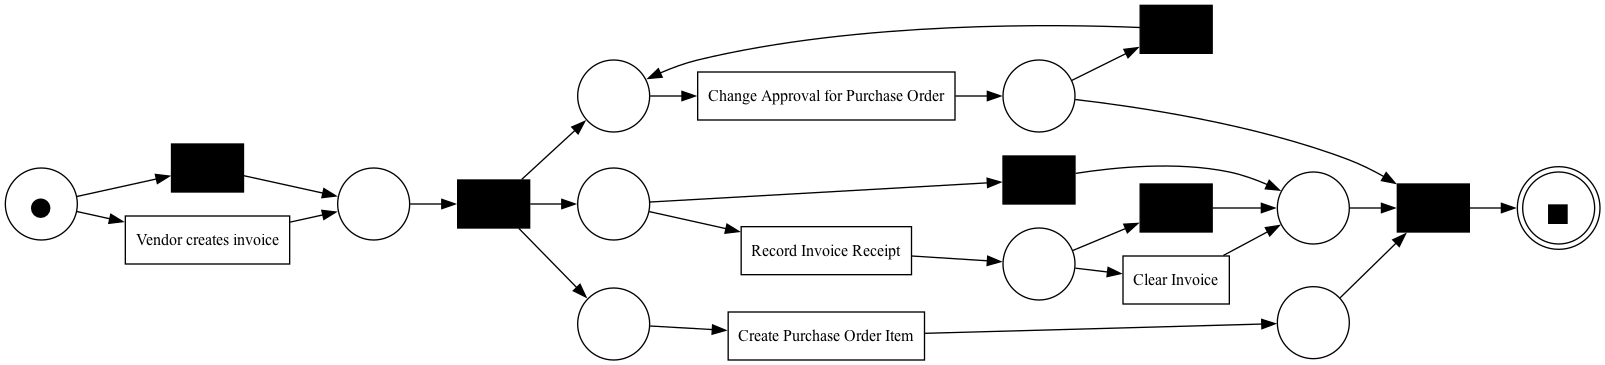

Showing analysis for Item Category: Consignment
[INFO] Subset 'Consignment': 36,084 events, 14,498 cases

[PROCESS MODEL] Category: Consignment
Events: 36,084, Cases: 14,498


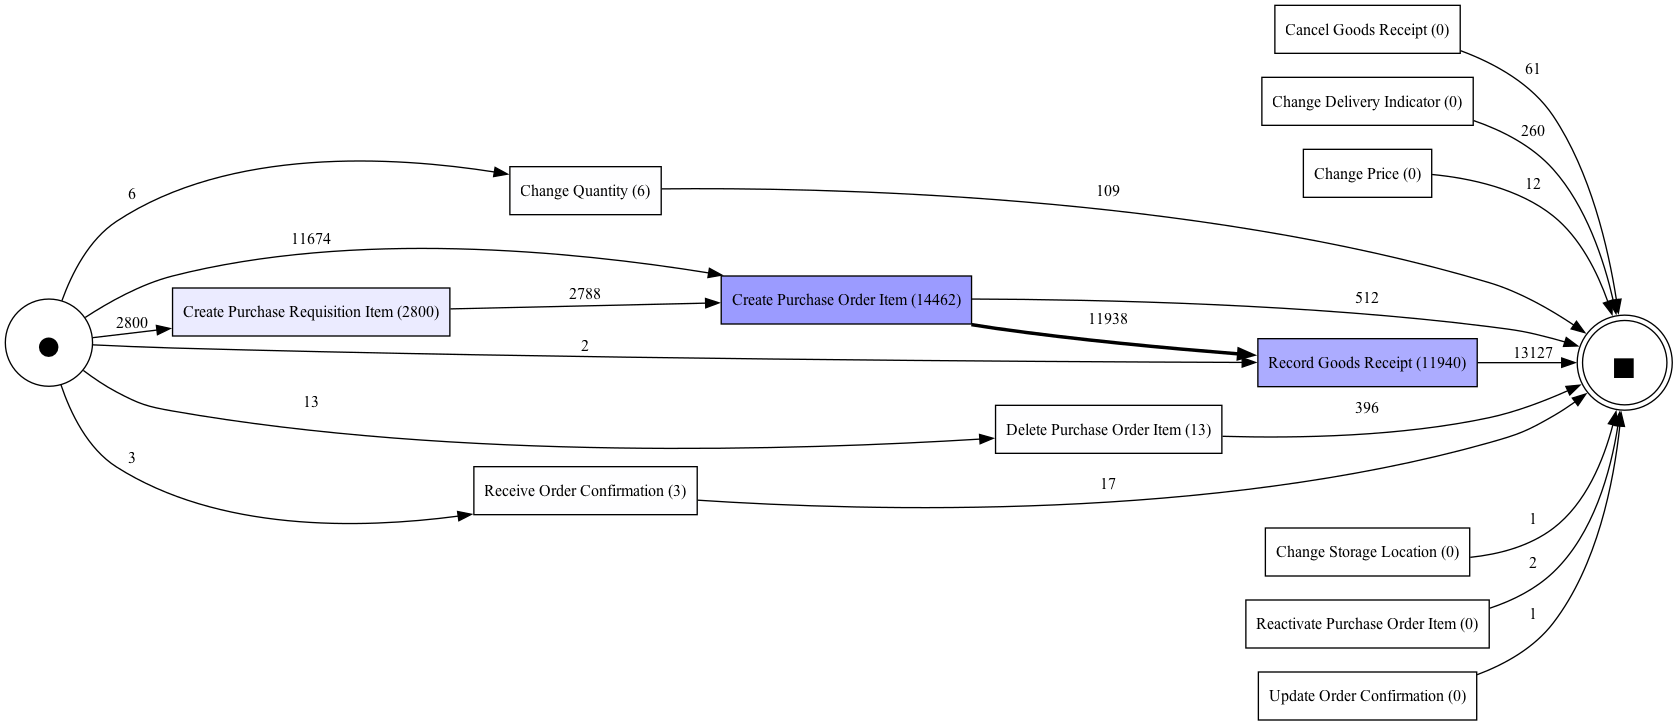

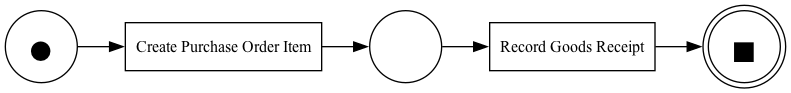

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from wise.analysis.wise_bpic19_modular import (
    load_settings_and_paths,
    load_log,
    subset_by_item_category,
    build_case_features,
    compute_wise_case_scores,
    enrich_case_full,
    aggregate_slices,
    show_for_category,
)

sns.set_theme(style="whitegrid")
# set path for loading data from /Users/ula/code/PhD/WISE/WISE/Untitled/src/wise/analysis/data/results_BPIC_2019
data_path = Path("/Users/ula/code/PhD/WISE/WISE/Untitled/src/wise/analysis/data/results_BPIC_2019")

process_type = "3-way match invoice after GR"
settings, paths = load_settings_and_paths()

case_id_col = settings["CASE_COLS"]["CASE_ID_COL"]
act_col     = settings["CASE_COLS"]["ACTIVITY_COL"]
ts_col      = settings["CASE_COLS"]["TIMESTAMP_COL"]

data = { "df_full" : pd.read_csv(data_path / "bpic19_raw_log.csv"), 
        "df_subset" : pd.read_csv(data_path / "df_subset_3-way_match_invoice_after_GR.csv"), 
        "case_features" : pd.read_csv(data_path / "case_features_3-way_match_invoice_after_GR.csv"), 
        "case_scores" : pd.read_csv(data_path / "case_scores_3-way_match_invoice_after_GR.csv"), 
        "case_full" : pd.read_csv(data_path / "case_full_3-way_match_invoice_after_GR.csv"), 
        "slice_summary" : pd.read_csv(data_path / "slice_summary_3-way_match_invoice_after_GR.csv"), }

# loop over case Item Category in df_full and show analysis for each category
for category in data["df_full"]["case Item Category"].unique():
    print(f"Showing analysis for Item Category: {category}")

    df_subset = subset_by_item_category(
        df=data["df_full"],
        cat_value=category,
        category_col="case Item Category",
        case_id_col=case_id_col,
    )
    show_for_category(
        df_subset=df_subset,
        category_name=category,
        case_id_col=case_id_col,
        act_col=act_col,
        ts_col=ts_col,
        percentile=0.6,
    )



### 1 3-way match, invoice before GR

(~1,234,708 events, 221,010 cases)

#### 1.1. Business meaning

This pattern corresponds to POs where the supplier sends the invoice before the goods/service are recorded as received in the system.

In SAP/ERP terms this usually leads to:

- invoice posting,

- automatic payment block or a “blocked for payment” status,

- later GR or service entry sheet,

- removal of block and clearing.

In BPIC 2019 model:

You see paths where:

**Vendor creates invoice → Record Invoice Receipt → (blocked) → later Record Goods Receipt / Record Service Entry Sheet → Clear Invoice.**

There are additional paths for price/quantity changes, approval changes, and cancellations.

#### 1.2. Why would a company use this flow?

Pre-billing: vendors bill before actual delivery (common in professional services, subscriptions, retainers).

Early invoice registration: AP wants invoices in the system early to track liabilities, but blocks payment until GR or service confirmation is posted.

#### 1.3. Typical problems

From a process-mining and improvement perspective, this flow is prone to:

- Long “blocked invoice” periods

- GR/service confirmations are recorded late ⇒ inv_to_clear_days is high.

In the model, you see a large gap between Record Invoice Receipt and Clear Invoice.

- Mismatch between invoice and later GR

- Quantities or prices differ once services are actually confirmed.

- Leads to Change Price, Change Quantity, or even cancellations.

- High manual effort and unclear ownership

Many cases involve several users: AP, requestor, approver, vendor management.

The model shows loops around change/approval steps and “Remove Payment Block”.

Control risk

Invoices present in the system without corresponding GR may be overlooked.

If blocks are released without proper confirmation, there is a risk of paying for undelivered items.

#### 1.4. Typical KPIs and constraint suggestions

##### Operational & Finance KPIs

- Share of invoices blocked for missing GR/SES

**KPI: % invoices with payment block due to missing GR/SES.**

- Why: quantifies how often the “invoice-before-GR” pattern leads to manual resolution.

- Average and 90th percentile of inv_to_clear_days for blocked invoices

**KPI: median/90% INV→CLEAR (days) for blocked invoices.**

- Why: directly measures how long invoices sit blocked in the system.

- Mismatch rate between invoice and subsequent GR

**KPI: % of cases where GR/SES quantity or price differs from invoice.**

- Why: indicates quality of pre-billing and master data.

- Rework rate around block resolution

**KPI: avg.# Change Price/Change Quantity/Remove Payment Block per blocked invoice.**

- Why: approximates manual effort and complexity.

##### **WISE-style constraint suggestions**

**L1 Presence**

GR or SES must be present for every cleared invoice.

Why: ensures that payment can’t be considered “in norm” without a matching receipt.

**L2 Order/Lag***

Record Invoice Receipt → Record GR/SES within max 10 days (logistics view)

Record GR/SES → Clear Invoice within max 20–30 days (finance view)

Why: splits the long blocked period into manageable segments that can be monitored.

**L3 Balance (if used)**

GR/SES quantity and invoice quantity must match within tolerance X%.

Why: addresses the mismatch risk between early invoice and later confirmation.

**L4 Singularity**

Change Price and Change Quantity at most once per invoice-before-GR case.

Why: allows one correction but flags cases that are stuck in negotiation loops.

**L5 Exclusion**

Cancel Invoice Receipt after GR/SES should be rare and flagged as hard violation.

Why: cancellation after full information is a red flag for process or data issues.

### 2. 3-way match, invoice after GR

(~319,233 events, 15,182 cases)

##### 2.1. Business meaning
This is the ***“textbook 3-way match”:***

-> Create PO item

-> Receive goods or services (Record Goods Receipt / Record Service Entry Sheet)

-> Vendor sends invoice (Vendor creates invoice → Record Invoice Receipt)

-> Invoice is matched against PO & GR, then Clear Invoice.

The DFG and Petri net for this subset show a relatively clean path:

PO creation → GR/SES → Vendor invoice → Invoice receipt → Clear invoice.

##### 2.2. Why this flow is preferred

Finance can safely pay because GR already exists.

Logistics/operations confirm quantity and quality before liability is recorded.

Automated 3-way match can be used to enable touchless processing.

##### 2.3. Typical problems

Even in the “ideal” flow, BPIC’19 shows several issues, especially in Logistics:

Fragmented GR and SES

Many GRs (e.g. multiple partial receipts per PO line) ⇒ n_gr high.

The first GR may be posted early, but follow-up confirmations are delayed.

Multiple changes and rework

Change Price and Change Quantity loops to align PO with reality.

Change Storage Location, Change Delivery Indicator in the DFG for service flows.

Late invoicing or clearing

Vendors invoice long after the GR (high gr_to_inv_days).

AP clears invoices late (high inv_to_clear_days), sometimes due to blocks.

Cancellations

Cancel Goods Receipt and Cancel Invoice Receipt appear as side paths.

These indicate wrong postings, changed demand, or data-entry errors.

#### 2.4. Typical KPIs and constraint suggestions

Operational & Finance KPIs

End-to-end P2P cycle time

**KPI: median/90% PO→CLEAR (days) per spend area.**

- Why: measures overall efficiency of the classic 3-way process.

- GR→INV and INV→CLEAR lags

**KPI: median/90% GR→INV (days) and INV→CLEAR (days) per slice.**

- Why: show whether vendors invoice promptly after receipt and AP clears within target timelines.

- **GR fragmentation indicator**

**KPI: avg.# GR events per case and % cases with >1 GR.**

- Why: high fragmentation correlates with complexity and potential mismatches.
Rework and change rate

**KPI: avg.# Change Price/Change Quantity per case and % cases with any change.**

- Why: shows how often PO data needs correction after GR and before/after invoice.

Cancellation rate

**KPI: % cases with Cancel Goods Receipt / % cases with Cancel Invoice Receipt.**

- Why: high cancellation rates highlight reliability issues in order entry or delivery.

##### WISE-style constraint suggestions

***L1 Presence***

Create PO, GR/SES, INV, and CLEAR must all be present for cases considered “successful 3-way” (for Finance view).

Why: formalises the expected lifecycle of a 3-way line.

***L2 Order/Lag***

GR/SES → INV ≤ 10 days (Logistics-heavy view)

INV → CLEAR ≤ 30 days (Finance-heavy view)

Why: matches policy-type thresholds and links directly to throughput KPIs.

***L3 Balance***

Sum(GR quantities) ≈ INV quantity within ±X%.

Sum(GR amounts) ≈ INV amount within ±X%.

Why: prevents drift between delivery and invoice, especially with many partial GRs.

***L4 Singularity***

Change Price at most once after GR;

Change Quantity at most once after GR;

optional: max number of GRs for certain spend areas (e.g. ≤ 3 per line).

Why: enforces “stability” after receipt and highlights heavy rework cases.

***L5 Exclusion***

Cancel GR and Cancel Invoice Receipt after CLEAR should be forbidden or heavily penalised.

Why: protects against late reversals that can mask deeper control issues.

### 3. 2-way match

(~5,898 events, 1,044 cases)

##### 3.1. Business meaning
In a 2-way match, there is no goods receipt in the system:

-> PO item is created,

-> Vendor sends invoice,

-> Invoice is matched directly against the PO,

-> Invoice is cleared.

This is common for:

low-risk services or recurring items (subscriptions, utilities),

situations where physical receipt is not recorded (e.g. cloud services).

In BPIC 2019 models:

You see paths where Create Purchase Order Item goes directly to Record Invoice Receipt and then Clear Invoice.

GR-related activities are absent, confirming the 2-way structure.

##### 3.2. Typical problems

- Weak control over actual delivery/consumption

- No formal GR or SES means the system doesn’t check whether services were actually rendered.

- Risk: paying for something not (yet) received or not needed anymore.

- Misuse of 2-way where 3-way is more appropriate

- Some categories might use 2-way out of habit, even though there is a tangible delivery.

- Leads to gaps in inventory / asset tracking.

- Price/quantity mismatches only caught at invoice stage

- Change Price or Change Quantity events appear when AP notices inconsistencies.

- Corrective work is done late, possibly impacting closing and budgeting.

#### 3.3. Typical KPIs and constraint suggestions

Operational & Control KPIs

Share of spend handled as 2-way

**KPI: % of total spend / #PO lines by item category ≈ 2-way.**

- Why: ensures 2-way is only used where intended (low-value, low-risk).

- Invoice-to-clear time

**KPI: median/90% INV→CLEAR (days) for 2-way items.**

- Why: even without GR, Finance wants quick processing.
Manual intervention rate

**KPI: avg.# manual events per 2-way case (changes, approvals, comments).**

- Why: reveals whether 2-way is truly simpler or just “hiding complexity”.

Price/quantity correction rate

**KPI: % 2-way cases with Change Price/Quantity.**

- Why: if many 2-way items need later corrections, the lack of GR is not the real issue – master data or contracting is.

##### WISE-style constraint suggestions

**L1 Presence**

For 2-way, require Create PO and INV (and optionally CLEAR) but explicitly no GR/SES expectation.

Why: ensures norms reflect the correct process type.

**L2 Order/Lag**

PO Create → INV ≤ N days (e.g. 30) to avoid extremely late invoicing.

INV → CLEAR ≤ M days (e.g. 30) to keep payables under control.

Why: 2-way is often used for recurring services; long delays are still problematic.

**L3 Balance**

PO amount ≈ INV amount within ±X% (no GR to mediate).

Why: ensures that missing GR is compensated by stricter PO–invoice consistency.

**L4 Singularity**

Change Price or Change Quantity at most once per 2-way line.

Why: multiple changes in a 2-way scenario indicate that no one is really checking usage or contract terms.

**L5 Exclusion**

For 2-way items, Cancel Invoice Receipt should be rare; treat presence as hard violation.

Why: cancellations in a weakly controlled flow require attention.

### 4. Consignment

(~36,084 events, 14,498 cases)

#### 4.1. Business meaning

In a consignment scenario, goods are physically held by the buyer but owned by the supplier until they are consumed.

Typical flow:

-> Create consignment PO,

-> Record Goods Receipt for stock going into consignment (not yet purchased),

-> When stock is consumed, a settlement process or consumption posting creates the invoice,

-> Invoice is cleared.

In many SAP-driven consignment settings, the actual invoice items may not appear in the same operational P2P log; settlement may be handled:

-> in a separate module,

-> as periodic settlement runs,

-> in aggregated form.
In BPIC 2019 consignment DFG:

You see Record Goods Receipt and Record Service Entry Sheet but often no Record Invoice Receipt or Clear Invoice in the same log slice.

There are also paths involving Vendor creates debit memo, hinting at adjustment postings.

#### 4.2. Typical problems

Visibility of liability and cost

Because PO → GR does not lead to immediate invoice, Finance may have difficulty estimating liabilities if settlement is delayed.

Stock and consumption inaccuracies

If consumption postings are late or wrong, the vendor’s periodic settlement will not match true usage.

This can lead to disputes, retro corrections, and high L3/L4 issues in WISE when settlement events are eventually logged.

Fragmented process across systems

The DFG suggests that consignment involves different event sets and possibly different systems (SRM, consignment settlement).

Process mining on only one log may show an apparently “broken” flow; interpretation must account for cross-system gaps.

#### 4.3. Typical KPIs and constraint suggestions

Operational & Inventory/Finance KPIs

Consignment consumption coverage

**KPI: % of consignment GRs with corresponding consumption postings within k days (e.g. 30 or 60).**

- Why: measures how quickly physical usage is recognised in the system.

- Ageing of consignment stock

**KPI: distribution of days since GR with no consumption per consignment line.**

- Why: identifies slow-moving or obsolete consignment stocks.
Settlement timeliness

**KPI: median/90% time from consumption (or settlement run) to invoice, where such events are in scope.**

- Why: ensures supplier and buyer view of liability converge promptly.

Adjustment / debit memo rate

**KPI: % consignment cases with debit memo / cancellations.**

- Why: high rate suggests inaccurate consumption or valuation.

##### WISE-style constraint suggestions (consignment-specific norm)

**L1 Presence**

GR and some form of consumption/settlement marker must be present for lines that are eventually invoiced.

Why: encodes the two key steps: stock enters consignment; stock is consumed/settled.

**L2 Order/Lag**

GR → consumption within max C days for fast-moving items.

Consumption/settlement → invoice within max S days.

Why: ensures stock and liability recognition converge within reasonable time; long open consignment stock is risky.

**L3 Balance**

Total consumption quantity ≈ invoiced quantity within tolerance.

Why: protects against under-/over-billing over multiple settlement cycles.

**L4 Singularity**

Limit number of Cancel GR, Cancel consumption, or manual adjustments per line (e.g. at most 1).

Why: repeated reversals indicate poor discipline in booking usage.

**L5 Exclusion**

Certain combinations (e.g. Cancel GR long after consumption) should be treated as hard violations.

Why: they break the expected physical–financial traceability of consignment flows.

### 5. How to use these interpretations in BPIC 2019 analysis

When you look at the discovered models and the log statistics you posted:

'3-way match, invoice before GR': 1,234,708 events, 221,010 cases
'3-way match, invoice after GR' :   319,233 events,  15,182 cases
'2-way match'                    :     5,898 events,   1,044 cases
'Consignment'                    :    36,084 events,  14,498 cases


we can combine volume and risk:

3-way-before-GR is the largest population and suffers from blocked invoice risk → high-priority candidate for L2 norm tuning and SLA work.

3-way-after-GR should be the “best behaved” but your models show many changes, cancellations and complex loops, especially for Logistics → target for simplifying GR and reducing rework.

2-way is small but control-wise sensitive → review where it is allowed; use WISE to flag suspicious slices.

Consignment has a different lifecycle and may require a separate WISE norm and dedicated process mining analysis.

## 2. Why these constraints make sense for BPIC'19

### 2.1. Presence constraints (L1)

In BPIC’19, PO line items are expected to follow a standard P2P lifecycle:

1. **Create PO item**  
2. **Record GR** (except for 2-way or consignment in some categories)  
3. **Record INV**  
4. **Clear INV**

The four L1 presence constraints in the norm capture this in a simplified,
“Finance + Logistics friendly” way:

- Finance cares that every relevant line item eventually yields an invoice and
  a clearing event, because:

  - accounts payable KPIs (e.g. blocked invoice days) depend on it,
  - completeness of liabilities and expense recognition is at stake.

- Logistics cares that every line item has a GR where expected:

  - on-time receipt confirmation is needed for inventory and service-level KPIs,
  - missing GR often indicates poor booking discipline or missing confirmations
    from the floor or external providers.

Presence constraints therefore link directly to:

- **Finance KPIs**: invoice completeness, open items, blocked invoices,
- **Logistics KPIs**: receipt completeness, delivery confirmation rates.

### 2.2. Order/Lag constraints (L2)

In BPIC’19 challenge text and submissions, the *timing* of GR, INV and CLEAR
is a central concern:

- late **GR** leads to late invoices and poor accruals,
- long **INV→CLEAR** intervals mean blocked or overdue invoices,
- the company asked explicitly about **invoicing throughput** and delays.

The norm captures this through two lag constraints:

- GR→INV ≤ 10 days (weighted more for Logistics),
- INV→CLEAR ≤ 30 days (weighted more for Finance).

From a business perspective:

- Logistics wants GR to be recorded soon after physical receipt, and invoice
  posting should follow fairly quickly → GR→INV lag is important.
- Finance wants invoices to be cleared in a timely manner → INV→CLEAR lag
  is tied to their **blocked invoice days** and DPO (days payable outstanding)
  KPIs.

The asymmetric weights reflect that:

- **Logistics view** puts more emphasis on `c_l2_gr_to_inv` (0.4 vs 0.2),
- **Finance view** puts more emphasis on `c_l2_inv_to_clear` (0.4 vs 0.2).

### 2.3. Singularity constraints (L4)

The BPIC’19 log is rich in **change events** (`Change Price`, `Change Quantity`)
and the challenge reports repeatedly comment on:

- many small changes and re-bookings,
- adjustments made after GR or even after INV.

From a process-improvement standpoint:

- repeated price or quantity changes per PO line often indicate:

  - unstable contracts,
  - poor master data,
  - informal negotiations after initial PO creation.

The two L4 singularity constraints:

- `Change Price` at most once,
- `Change Quantity` at most once,

translate this into a simple, measurable expectation:

> There can be some rework, but it should not turn into a pattern of endless
> adjustments; more than one change is treated as a violation.

Finance weights `Change Price` slightly higher (0.2 vs 0.1), since price
changes impact GL posting and reconciliation, while Logistics emphasises
quantity changes more (0.2 vs 0.1).

### 2.4. Exclusion constraints (L5)

BPIC’19 contains `Cancel Invoice Receipt` and `Cancel Goods Receipt` events.

- Frequent **invoice cancellations** often point to upstream issues
  (wrong vendor, wrong amount, duplicate invoices).
- Frequent **GR cancellations** suggest operational or data-entry problems
  (wrong warehouse, mis-scanned deliveries).

The L5 constraints:

- `Cancel Invoice Receipt` should not happen,
- `Cancel Goods Receipt` should not happen,

model these as **hard red flags**.

Finance views cancellation of invoices as more severe (weight 0.3 vs 0.1),
because it creates extra accounting effort and may mask deeper control issues.
Both views assign some weight to `Cancel Goods Receipt`, but lower (0.2 vs 0.1).

---

## 3. Simulated workshops – eliciting the norm

This section sketches how such a norm could be elicited in mixed workshops
with Finance, Logistics, and process improvement experts. The aim is to show
**who would say what** and how the JSON entries emerge.

### 3.1. Workshop 1 – Goal alignment and KPIs

**Participants:**

- Head of Finance (AP/GL),
- Head of Logistics / Supply Chain,
- Process Mining Analyst,
- Internal Control / Compliance,
- IT representative.

**Agenda:**

1. Clarify P2P objectives and pain points.
2. Map existing KPIs.
3. Decide which process types to start with.
4. Identify “must have” events and sequencing.

**Dialogue sketch.**

- *Finance*:  
  “Our main pain points are blocked invoices and late payments. We also care
  about whether all delivered goods are eventually invoiced and cleared.”

- *Logistics*:  
  “For us the priority is that goods receipts are posted promptly and that
  quantity mismatches are minimal; otherwise inventory and service levels are
  unreliable.”

- *Analyst*:  
  “In BPIC’19 we see four main flows (3-way after GR, 3-way before GR, 2-way,
  consignment). For our first norm we suggest focusing on the classic 3-way
  after GR, where all four steps – Create, GR, INV, CLEAR – are expected.”

- *Compliance*:  
  “Cancellations and late price changes are also concerning; they can hide
  control weaknesses.”

From this discussion, the analyst proposes:

- L1 Presence constraints for the four core activities,
- L2 Order/Lag constraints based on current policies (10 and 30 day windows),
- L4 and L5 rules around changes and cancellations.

This leads to a **first draft** of the `constraints` section.

### 3.2. Workshop 2 – Layer by layer

**Participants:**

- Finance team (AP lead, GL), 
- Logistics team (warehouse, transport),
- Analyst facilitating.

#### L1 Presence (activities must occur)

- *Analyst*:  
  “For a ‘good’ 3-way PO we expect at least one `Create PO`, `Record GR`,
  `Record Invoice Receipt`, and `Clear Invoice`. Are there exceptions?”

- *Logistics*:  
  “For consignment we often don’t see invoice; but for our core population we
  want all four – especially GR and CLEAR.”

- *Finance*:  
  “Agreed. `Clear Invoice` is essential; open items or partially cleared items
  are part of another analysis.”

They agree on:

- four L1 constraints with equal base weight (1.0),
- moderate view weights: **Finance** emphasises INV & CLEAR, **Logistics**
  emphasises GR and CLEAR.

This is reflected as:

- `c_l1_create_po`: Finance 0.2, Logistics 0.2  
- `c_l1_gr`: Finance 0.2, Logistics 0.3  
- `c_l1_inv`: Finance 0.3, Logistics 0.2  
- `c_l1_clear`: Finance 0.3, Logistics 0.3.

#### L2 Order/Lag (timeliness)

- *Analyst*:  
  “Current policies mention that within 10 days of GR the invoice should be
  posted, and invoices should be cleared within 30 days. Are these still
  realistic?”

- *Finance*:  
  “30 days for clearance is our basic target. Some invoices can take longer
  due to disputes, but we treat that as deviation.”

- *Logistics*:  
  “10 days from GR to invoice is actually too long; historically we accept up
  to 10 days, but anything above that is problematic for our accruals.”

They decide to encode:

- GR→INV ≤ 10 days (weight 0.4 in Logistics, 0.2 in Finance),
- INV→CLEAR ≤ 30 days (weight 0.4 in Finance, 0.2 in Logistics).

#### L4 Singularity (rework)

- *Analyst*:  
  “We see many `Change Price` and `Change Quantity` events per case. How many
  are acceptable?”

- *Finance*:  
  “One change, maybe due to an agreed discount or correction, is acceptable.
  More than that suggests deeper issues.”

- *Logistics*:  
  “For quantity, we might allow a bit more flexibility, but repeated changes
  usually indicate poor planning or confirmation issues.”

They agree on:

- at most one `Change Price`,
- at most one `Change Quantity`.

Finance weights `Change Price` more strongly (0.2 vs 0.1), Logistics weights
`Change Quantity` more (0.2 vs 0.1).

#### L5 Exclusion (forbidden events)

- *Compliance*:  
  “Cancellations should be rare; they create audit questions and manual work.
  Let us treat them as ‘should not happen’ in the norm.”

- *Finance*:  
  “We consider invoice cancellations more severe than GR cancellations.”

Thus:

- `Cancel Invoice Receipt`: Finance 0.3, Logistics 0.1,
- `Cancel Goods Receipt`: Finance 0.2, Logistics 0.1.

---

## 4. Workshop 3 – Weights and views

This workshop focuses on **weighting**.

**Participants:**

- Finance manager,
- Logistics manager,
- Analyst.

**Objective:**  
Turn the qualitative statements (“we care more about this than that”) into
numeric view weights.

### 4.1. Direct rating

Analyst proposes a simple **direct rating** exercise per view:

1. Start with a list of constraints.
2. For each view (Finance, Logistics), distribute 100 “points” over the
   constraints by relative importance.

Example whiteboard for **Finance**:

| Constraint                      | Points |
|---------------------------------|--------|
| L1 Create PO                    | 10     |
| L1 GR                           | 10     |
| L1 INV                          | 20     |
| L1 CLEAR                        | 20     |
| L2 GR→INV lag                   | 10     |
| L2 INV→CLEAR lag                | 20     |
| L4 Change Price once            | 5      |
| L4 Change Quantity once         | 5      |
| L5 Cancel Invoice               | 15     |
| L5 Cancel GR                    | 10     |

Normalising by dividing each value by 100 gives approximately the weights in
the JSON. Some rounding and simplification is applied to keep numbers neat
(0.1, 0.2, 0.3, 0.4).

Similarly for **Logistics**:

| Constraint                      | Points |
|---------------------------------|--------|
| L1 Create PO                    | 10     |
| L1 GR                           | 15     |
| L1 INV                          | 10     |
| L1 CLEAR                        | 15     |
| L2 GR→INV lag                   | 20     |
| L2 INV→CLEAR lag                | 10     |
| L4 Change Price once            | 5      |
| L4 Change Quantity once         | 10     |
| L5 Cancel Invoice               | 5      |
| L5 Cancel GR                    | 5      |

After normalisation and rounding, this yields:

- high Logistics weight on GR→INV (0.4),
- moderate on GR presence and CLEAR presence (0.3),
- smaller weights on cancellations and price changes.

The JSON essentially encodes the **outcome** of these rating exercises.

### 4.2. Alignment check

Before finalising, the analyst checks:

- Are Finance and Logistics weights **comparable** at layer level?
- Does each view still “see” all constraints with some weight (none at zero)?

They agree that:

- shared constraints (`Clear Invoice`, cancel events) remain visible in both
  views,
- but each view emphasises its own pain points more strongly.

---

## 5. How the norm is used in practice

### 5.1. From norm to case scores

Given an event log (e.g. the BPIC’19 3-way-after-GR subset), the WISE
engine applies each constraint to each case:

- L1 constraints: check if each expected activity occurs at least once;  
  missing event yields a violation near 1.
- L2 constraints: compute observed lags (in days), map overtime to a
  violation in [0,1].
- L4 constraints: count change events; more than one yields violations.
- L5 constraints: presence of cancellations yields violation 1.

Per view (Finance or Logistics), the violation components are weighted by
`view_weights` and summed to get `1 - S^{(v)}(\sigma)` (badness).

### 5.2. From case scores to slice priorities

Case scores are then aggregated by slices such as:

- `Company × Spend area × Item category`,
- `Spend area × behavioural cluster`,
- `Company × automation level`.

For each slice:

- compute `mean_score` and `shrunk_score`,
- compute gap vs global and Priority Index,
- plot layer-wise averages per slice.

This yields dashboards like:

- “Top 10 worst slices in Finance view”,
- “Layer-wise heatmap for Logistics view”.

The norm thus provides:

- a **shared vocabulary** for deviations (presence, lag, singularity,
  exclusion),
- a **structured way** to rank slices across Finance and Logistics.

---

## 6. Playbook: how to run your own WISE norm workshop

This section summarises the steps as a reusable playbook.

### Step 1 – Pre-work: data profiling

- Run an initial process-mining analysis (e.g. with pm4py) on the log to
  identify:

  - main process types (3-way/2-way/consignment),
  - key lifecycle activities (Create, GR, INV, CLEAR),
  - common deviations (missing steps, late steps, cancellations, many changes).

- Prepare a short **diagnostic deck** with examples from BPIC’19:
  - spaghetti models vs simplified DFGs,
  - histograms of GR→INV and INV→CLEAR lags,
  - distributions of change/cancellation events.

### Step 2 – Goal alignment workshop

- Invite key stakeholders (Finance, Logistics, Process Owners, Compliance).
- Clarify:

  - business objectives (reduce blocked invoices, improve on-time receipt),
  - current KPIs and pain points,
  - scope (e.g. 3-way match after GR in specific companies/spend areas).

- Produce a **list of desired patterns** in plain language:

  - “Every PO line should have GR, INV, and CLEAR within X/Y days”,
  - “Price changes should be rare and early”,
  - “Cancellations should be exceptional”.

### Step 3 – Translate patterns into WISE layers

- For each pattern, decide:

  - Is it about **presence** (L1)?  
  - Is it about **order/timing** (L2)?  
  - Is it about **value/quantity mismatch** (L3, if used)?  
  - Is it about **repetition** (L4)?  
  - Is it about **forbidden events** (L5)?

- Draft preliminary constraints with:

  - `layer_id` (e.g. `presence`, `order_lag`, `singularity`, `exclusion`),
  - `params` (activities, max_days, tolerances).

### Step 4 – Weight elicitation per view

- For each view (Finance, Logistics, perhaps later Compliance/Automation):

  - Provide stakeholders with a **constraint list**.
  - Ask them to distribute 100 “importance points” over constraints.
  - Normalise to weights in [0,1] and round.

- Document the rationale:

  > “Finance emphasises INV→CLEAR because of blocked invoice KPIs,”  
  > “Logistics emphasises GR presence and GR→INV lag for service-level KPIs.”

### Step 5 – Pilot run and calibration

- Apply the drafted norm to a sample of the log (e.g. several companies or a
  time window) and generate:

  - top/bottom slices for each view,
  - layer-wise heatmaps.

- Review with stakeholders:

  - Does the ranking reflect intuitive “where it hurts”?  
  - Are any obviously good slices ranked as bad (false positives)?  
  - Are any known problem areas missing from the top (false negatives)?

- Adjust max_days and weights where needed.

### Step 6 – Freeze and version the norm

- Once there is consensus:

  - save the norm as `BPIC_2019_norm_v1.json`,
  - record ownership (e.g. joint Finance/Logistics process owner),
  - define a review cycle (e.g. quarterly).

- Optionally, keep a **change log**:

  - “v1.1: increase GR→INV max_days from 10 to 12 for Logistics due to new SLA.”

### Step 7 – Use norm in continuous improvement

- Periodically re-run WISE analyses:

  - update slice rankings and PIs,
  - track movement of key slices (e.g. Logistics 3-way after GR),
  - monitor layer patterns (e.g. L4 violations decreasing after policy change).

- Use results as input to:

  - Kaizen workshops,
  - vendor negotiations (where patterns relate to specific suppliers),
  - automation roadmap (which clusters perform well with manual vs automated steps).

---

## 7. Domain-specific reflections for BPIC’19

The BPIC’19 case is particularly interesting because:

- it focuses on **non-product-related spend** (Logistics, Services, Marketing,
  CAPEX) where:

  - PO lines can be complex, long-running, and heavily negotiated,
  - many GRs and changes per line are common but not always desirable.

- the company’s questions combine:

  - classic process-mining topics (models, variants, throughput),
  - business concerns (blocked invoices, rework, vendor performance).

The norm in `BPIC_2019_norm.json` is a **lean but effective compromise**:

- It does not model every nuance (e.g. multiple item categories) but captures
  main Finance and Logistics concerns.
- It simplifies presence and lag expectations into a single set of global
  constraints (10/30 days) that are understandable and measurable.
- It acknowledges that some rework is acceptable (one change) but repeated
  changes move into violation territory.

Using this norm as a baseline, the company can:

- measure how often and where core expectations are violated,
- attribute deviations to specific slices and views,
- and design targeted interventions, especially in:

  - Logistics (GR discipline, GR→INV lag, quantity changes),
  - Finance (INV→CLEAR lag, invoice cancellations),
  - cross-functional policies around price changes and cancellations.

---

## 8. Summary

This playbook has:

- unpacked the WISE BPIC’19 norm into its constituent constraints and views,
- shown how each constraint ties back to P2P business goals and KPIs,
- simulated stakeholder workshops to elicit and weight constraints,
- outlined a step-by-step method for turning informal expectations into a
  formal, versioned norm,
- and reflected on why this norm is well-suited for the BPIC’19 domain.

By following the same pattern in other organisations, process owners can
systematically define **what good looks like** in P2P, evaluate it on event
logs using WISE, and prioritise improvement efforts based on norm-based
deviations that Finance, Logistics and other stakeholders understand and own.
